# Create Weather Data

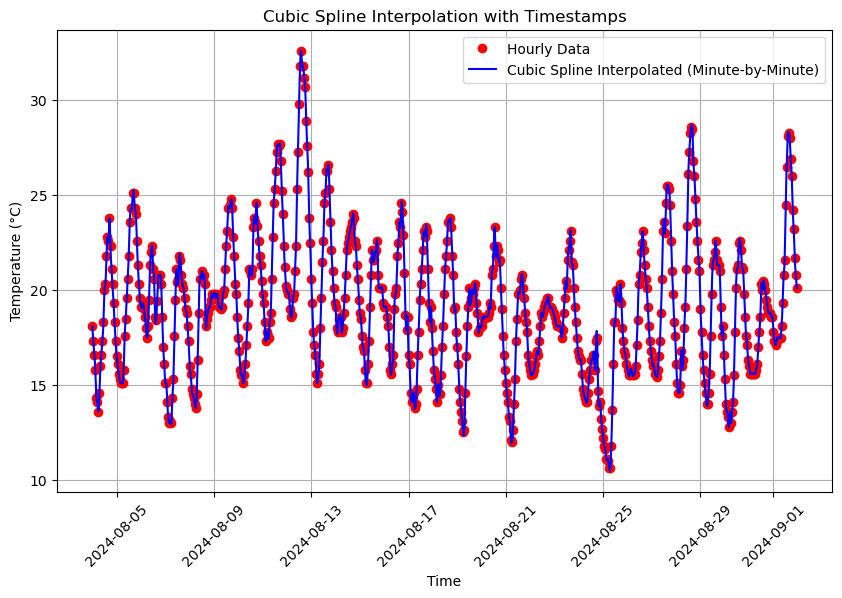

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from scipy import interpolate

# Read the weather data
weather_data = pd.read_csv('../Utilities/csv/weather_data/london_weather_data.csv')

# Ensure 'datetime' is parsed as a datetime format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# Set 'datetime' as the index
weather_data.set_index('datetime', inplace=True)

# Sort the data by datetime (important before resampling)
weather_data = weather_data.sort_index()

# Resample the data to minute-level frequency ('T' for minute)
# This will create gaps in between hour-level data points
weather_data_resampled = weather_data.resample('T').asfreq()

# Use cubic interpolation to fill the gaps
weather_data_resampled[['temp', 'humidity', 'windspeed']] = weather_data_resampled[['temp', 'humidity', 'windspeed']].interpolate(method='cubic')

weather_data.reset_index(inplace=True)
weather_data_resampled.reset_index(inplace=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(weather_data['datetime'], weather_data['temp'], 'o', label='Hourly Data', color='red')
plt.plot(weather_data_resampled['datetime'], weather_data_resampled['temp'], label='Cubic Spline Interpolated (Minute-by-Minute)', color='blue')
plt.title('Cubic Spline Interpolation with Timestamps')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Save the dataset to a CSV file
file_path = "../Utilities/csv/weather_data_minutes.csv"
weather_data_resampled[['datetime', 'temp', 'humidity', 'windspeed']].to_csv(file_path, index=False)


# Generate data

In [8]:
np.random.seed(42)  # For reproducible results

weather_data_resampled = pd.read_csv('../Utilities/csv/weather_data_minutes.csv')
# Generate CPU usage based on the inverse relationship with temperature
cpu_usage = [round(temp + np.random.uniform(-0.5, 0.5), 2) for temp in weather_data_resampled['temp']]

weather_data_resampled['CPU Usage (%)'] = cpu_usage

# Display the first few rows
weather_data_resampled.head()

# Define rush hour periods: 7:30-9:30am and 4:30-6:30pm each day
rush_hour_morning_start = '07:30:00'
rush_hour_morning_end = '09:30:00'
rush_hour_evening_start = '16:30:00'
rush_hour_evening_end = '18:30:00'

# Function to add spikes in CPU usage during rush hours on weekdays and fluctuations elsewhere
def add_data_spikes(df):
    for i, row in df.iterrows():
        time = pd.to_datetime(row['datetime']).time()
        date_format = '%Y-%m-%d %H:%M:%S'
        date_obj = datetime.strptime(str(row['datetime']), date_format)
        fluctuation_precentage = np.random.normal(0, 10)
        # df.at[i, 'Temperature (°C)'] = round(row['Temperature (°C)'] + fluctuation_precentage, 2)
        if (date_obj.weekday() <= 4 and ((rush_hour_morning_start <= time.strftime('%H:%M:%S') <= rush_hour_morning_end) or \
           (rush_hour_evening_start <= time.strftime('%H:%M:%S') <= rush_hour_evening_end))):
            # Add a spike in CPU usage, random boost between 20-40% during rush hours
            df.at[i, 'CPU Usage (%)'] = round(row['CPU Usage (%)'] + np.random.normal(20, 40), 2)
        else:
            df.at[i, 'CPU Usage (%)'] = round(row['CPU Usage (%)'] + fluctuation_precentage, 2)
    return df

# # Modified function to include hysteresis and simulate spikes in CPU usage
# def simulate_cpu_with_spikes_and_hysteresis(base_replicas=1, cpu_threshold=70, scale_down_wait=5, spike_probability=0.1):
#     duration_minutes = timestamps.size
#     cpu_usage = np.random.uniform(10, 100, size=duration_minutes)  # Random CPU usage between 10% and 100%

#     # Introduce random CPU spikes
#     spike_indices = np.random.choice(duration_minutes, int(duration_minutes * spike_probability), replace=False)
#     cpu_usage[spike_indices] = np.random.uniform(80, 100, size=len(spike_indices))  # CPU spikes from 80% to 100%

#     replicas = np.full(duration_minutes, base_replicas)
    
#     # Variable to track the last time CPU usage dropped below the threshold for hysteresis
#     time_below_threshold = -scale_down_wait  # Initialize as if the system can scale down immediately

#     # Adjust replicas based on the SLA threshold with hysteresis for scaling down
#     for i in range(1, duration_minutes):
#         if cpu_usage[i] > cpu_threshold:
#             replicas[i] = replicas[i-1] + 1  # Scale up if CPU usage exceeds the threshold
#             time_below_threshold = -scale_down_wait  # Reset scale down timer
#         elif cpu_usage[i] < cpu_threshold - 10 and replicas[i-1] > base_replicas:
#             if i - time_below_threshold >= scale_down_wait:
#                 replicas[i] = replicas[i-1] - 1  # Scale down if the system has been below the threshold long enough
#         else:
#             replicas[i] = replicas[i-1]  # Keep the same number of replicas
        
#         if cpu_usage[i] < cpu_threshold - 10:
#             time_below_threshold = i  # Update the time below threshold for hysteresis

#     # Create a DataFrame
#     data = pd.DataFrame({
#         'time': timestamps,
#         'cpu_usage': cpu_usage,
#         'replicas': replicas
#     })
    
#     return data

# Apply the rush hour spikes to the dataset
data_with_spikes = add_data_spikes(weather_data_resampled)

data_with_spikes_cleaned = data_with_spikes[(data_with_spikes[['CPU Usage (%)']] >= 0).all(axis=1)].copy()

data_with_spikes_cleaned.loc[:, 'temperature_lag_10_mins'] = data_with_spikes_cleaned['temp'].shift(10)
data_with_spikes_cleaned.loc[:, 'temperature_lag_1_hour'] = data_with_spikes_cleaned['temp'].shift(60)

# Drop rows with NaN values in place
data_with_spikes_cleaned.dropna(inplace=True)
print(data_with_spikes_cleaned.head())

# Generate the updated dataset with CPU spikes and hysteresis
# cpu_spikes_hysteresis_data = simulate_cpu_with_spikes_and_hysteresis()

# Plot the CPU usage and Temperature together
# fig, ax1 = plt.subplots(figsize=(10, 6))
# ax1.plot(data_with_spikes_cleaned['datetime'], data_with_spikes_cleaned['CPU Usage (%)'], 'g-', label='CPU Usage')
# ax1.set_xlabel('Timestamps')
# ax1.set_ylabel('CPU Usage (%)', color='g')
# ax1.tick_params('y', colors='g')
# ax2 = ax1.twinx()
# ax2.plot(data_with_spikes_cleaned['datetime'], data_with_spikes_cleaned['temp'], 'r-', label='Temperature')
# ax2.set_ylabel('Temperature (°C)')
# ax2.tick_params('y')
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.show()

correlation = data_with_spikes_cleaned['CPU Usage (%)'].corr(data_with_spikes_cleaned['temperature_lag_1_hour'])
print(f"Correlation between temperature and CPU Usage: {correlation}")
correlation = data_with_spikes_cleaned['CPU Usage (%)'].corr(data_with_spikes_cleaned['temperature_lag_10_mins'])
print(f"Correlation between temperature and CPU Usage: {correlation}")

temp_col = data_with_spikes_cleaned.pop('CPU Usage (%)')
data_with_spikes_cleaned.insert(1, 'CPU Usage (%)', temp_col)

# # Save the dataset to a CSV file
file_path = "../Utilities/csv/data_with_spikes_cleaned.csv"
data_with_spikes_cleaned.to_csv(file_path, index=False)

# # Save the dataset to a CSV file
# file_path = "../Utilities/csv/cpu_replicas.csv"
# cpu_spikes_hysteresis_data.to_csv(file_path, index=False)

               datetime       temp   humidity  windspeed  CPU Usage (%)  \
65  2024-08-04 01:05:00  17.235304  57.659503   8.126816          29.96   
66  2024-08-04 01:06:00  17.222458  57.700066   8.114196           1.20   
67  2024-08-04 01:07:00  17.209644  57.740837   8.102269          17.72   
68  2024-08-04 01:08:00  17.196865  57.781810   8.091044          24.82   
69  2024-08-04 01:09:00  17.184120  57.822979   8.080531          20.75   

    temperature_lag_10_mins  temperature_lag_1_hour  
65                17.365390               18.100000  
66                17.352262               18.086846  
67                17.339158               18.073669  
68                17.326079               18.060471  
69                17.313026               18.047252  
Correlation between temperature and CPU Usage: 0.20209457964486482
Correlation between temperature and CPU Usage: 0.22952762186201128


# Predict Workload

In [38]:
data = pd.read_csv('../Utilities\csv\data_with_spikes_cleaned.csv')

data.head()

data['datetime'] = pd.to_datetime(data['datetime'])

data.drop('datetime', axis=1, inplace=True)

features = ['temp', 'humidity', 'windspeed', 'temperature_lag_10_mins', 'temperature_lag_1_hour']
target = 'CPU Usage (%)'

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(data)

def create_sequences_multi_step(data, seq_length, pred_steps):
    sequences, labels = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        sequences.append(data[i:i + seq_length, :-1])  # Features (last hour of data)
        labels.append(data[i + seq_length:i + seq_length + pred_steps, -1])  # Predict next 10 values
    return np.array(sequences), np.array(labels)

# In 1 minute increments
prediction_steps = 10
prediction_lookup = 60
X, y = create_sequences_multi_step(scaled_data, prediction_lookup, prediction_steps)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(prediction_steps))  # Outputting 10 future values

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Checkppoint to ensure the best model is used - decided on best val_loss
model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
test_mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse}")

Epoch 1/5
493/493 [==============================] - ETA: 0s - loss: 0.0069
Epoch 1: val_loss improved from inf to 0.00141, saving model to best_model.hdf5
493/493 [==============================] - 136s 247ms/step - loss: 0.0069 - val_loss: 0.0014
Epoch 2/5


c:\Users\brand\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


493/493 [==============================] - ETA: 0s - loss: 0.0018
Epoch 2: val_loss improved from 0.00141 to 0.00021, saving model to best_model.hdf5
493/493 [==============================] - 172s 349ms/step - loss: 0.0018 - val_loss: 2.1031e-04
Epoch 3/5
493/493 [==============================] - ETA: 0s - loss: 0.0010
Epoch 3: val_loss did not improve from 0.00021
493/493 [==============================] - 166s 335ms/step - loss: 0.0010 - val_loss: 3.4972e-04
Epoch 4/5
493/493 [==============================] - ETA: 0s - loss: 7.1082e-04
Epoch 4: val_loss did not improve from 0.00021
493/493 [==============================] - 245s 497ms/step - loss: 7.1082e-04 - val_loss: 3.9609e-04
Epoch 5/5
493/493 [==============================] - ETA: 0s - loss: 5.5563e-04
Epoch 5: val_loss improved from 0.00021 to 0.00009, saving model to best_model.hdf5
247/247 [==============================] - 19s 78ms/step - loss: 8.5215e-05
Test MSE: 8.521512063452974e-05


# Forecast prediction

247/247 [==============================] - 18s 71ms/step
Mean Squared Error for one example: 0.011706085817927654


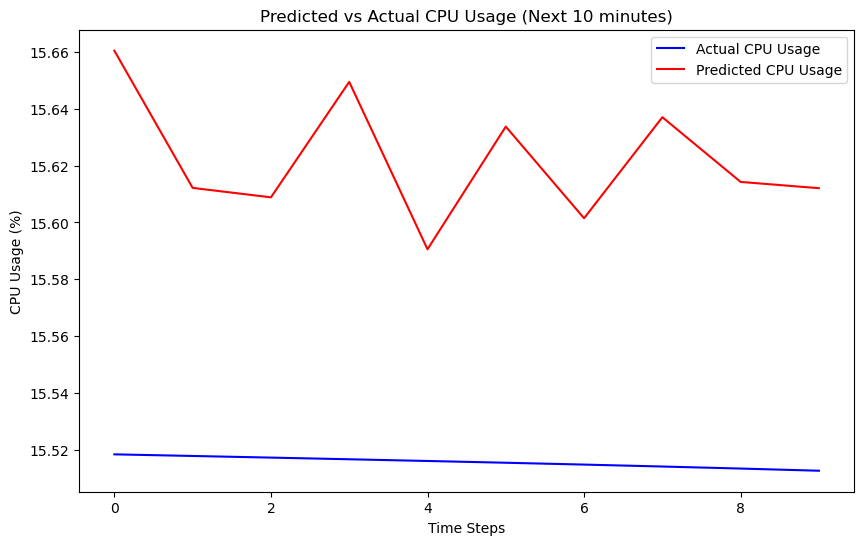

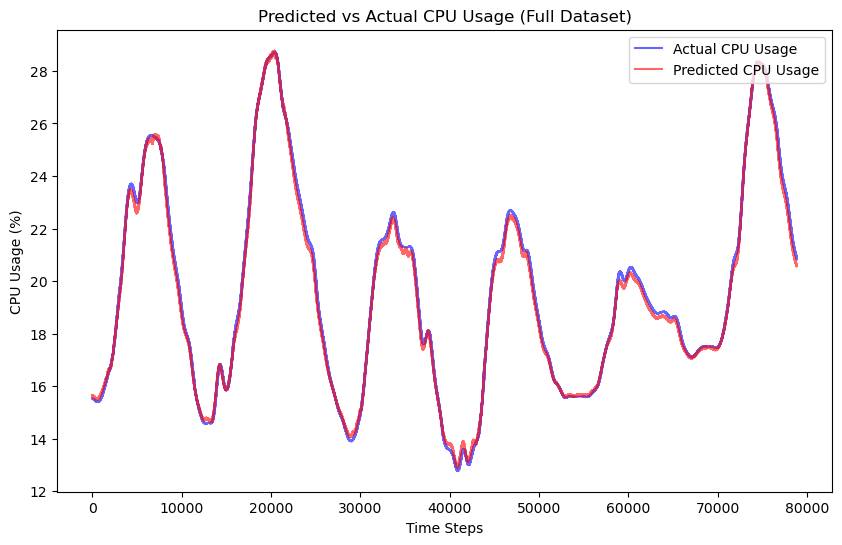

In [43]:
# Make predictions for the next 10 minutes (10 time steps)
predictions = model.predict(X_test)

# Rescale the predicted and actual values (only CPU usage, which is the last feature)
cpu_usage_scaler = MinMaxScaler()
cpu_usage_scaler.min_, cpu_usage_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

y_test_rescaled = cpu_usage_scaler.inverse_transform(y_test)
predictions_rescaled = cpu_usage_scaler.inverse_transform(predictions)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_rescaled[0], predictions_rescaled[0])
print("Mean Squared Error for one example:", mse)

# Plot the actual vs predicted values (for one example)
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[0], label='Actual CPU Usage', color='blue')
plt.plot(predictions_rescaled[0], label='Predicted CPU Usage', color='red')
plt.title('Predicted vs Actual CPU Usage (Next 10 minutes)')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
# Flatten the entire dataset for actual and predicted CPU usage
y_test_rescaled_flat = y_test_rescaled.flatten()
predictions_rescaled_flat = predictions_rescaled.flatten()
# Plot the entire dataset
plt.plot(y_test_rescaled_flat, label='Actual CPU Usage', color='blue', alpha=0.6)
plt.plot(predictions_rescaled_flat, label='Predicted CPU Usage', color='red', alpha=0.6)
plt.title('Predicted vs Actual CPU Usage (Full Dataset)')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend(loc='upper right')
plt.show()

# Predicting number of replicas

In [29]:
from sklearn.tree import DecisionTreeRegressor

replicas_data = pd.read_csv('../Utilities\csv/cpu_replicas.csv')
dtr_data_arr = np.array(replicas_data)

dtr_arr_cpu = dtr_data_arr[:, 1:2]
dtr_arr_replicas = dtr_data_arr[:, 2:3]

regressor = DecisionTreeRegressor(random_state = 0)

regressor.fit(dtr_arr_cpu, dtr_arr_replicas)

replicas_data_scaled = scaler.fit_transform(replicas_data['cpu_usage'])

# Make a CPU usage prediction
# forecast(<data to predict from>, <number of predictions>, <size of data to predict from>)
num_of_preds = 40
data_to_pred_from = 720
real_prediction = forecast(replicas_data_scaled,num_of_preds,data_to_pred_from).reshape(-1, 1)

transformed_pred = y_scaler.inverse_transform(real_prediction)

# predicting a new value  
y_pred_replicas = regressor.predict([transformed_pred[-1]])

# Print predicted CPU percentage
print("Predicted CPU Percentage: % f\n"% transformed_pred[-1])
print("Actual CPU Percentage: % f\n"% replicas_data['cpu_usage'][(num_of_preds+data_to_pred_from)])
# print the predicted replicas
print("Predicted Replicas: % d\n"% y_pred_replicas)
print("Actual Replicas: % f\n"% replicas_data['cpu_usage'][(num_of_preds+data_to_pred_from)])

# arange for creating a range of values 
# from min value of X to max value of X 
# with a difference of 0.01 between two 
# consecutive values 
X_grid = np.arange(min(dtr_arr_cpu), max(dtr_arr_cpu), 0.01) 

# reshape for reshaping the data into 
# a len(X_grid)*1 array, i.e. to make 
# a column out of the X_grid values 
X_grid = X_grid.reshape((len(X_grid), 1)) 

# scatter plot for original data 
plt.scatter(dtr_arr_cpu, dtr_arr_replicas, color = 'red') 

# plot predicted data 
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue') 

# specify title 
plt.title('Replicas to Pecentage CPU Usage (Decision Tree Regression)') 

# specify X axis label 
plt.xlabel('Percentage CPU Usage') 

# specify Y axis label 
plt.ylabel('Replicas') 

# show the plot 
plt.show() 



ValueError: Expected 2D array, got 1D array instead:
array=[39.84635545 86.36681408 67.88047103 ... 77.65568383 90.18948183
 35.96382217].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.